Después del estudio del dataset con los datos anuales, vamos a intentar mejorar las predicciones aumentando el número de muestras para cada empresa. Para esto usaremos un dataset con datos fundamentales con periodicidad trimestral, que juntaremos con datos mensuales de prices, usando interpolación para rellenar las filas en las que no disponemos de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
from pandas.plotting import lag_plot
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
#Transformación para series temporales donde cogemos el año como índice del dataframe
financialDF = pd.read_csv('Datos/financials_prices_quaterly_guru_rango_fechas_preprocesado.csv', sep=',', index_col=[0,1], header=0)
financialDF.head()

CS__CASH_FLOW_FOR_DIVIDENDS  \
Ticker FISCAL_YEAR                                
SVNLF  2005-12                              0.0   
       2006-12                              0.0   
       2007-12                              0.0   
       2008-12                              0.0   
       2009-12                              0.0   

                    CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS  \
Ticker FISCAL_YEAR                                               
SVNLF  2005-12                                             0.0   
       2006-12                                             0.0   
       2007-12                                             0.0   
       2008-12                                             0.0   
       2009-12                                             0.0   

                    CS__CHANGE_IN_DEFERREDTAX  CS__CHANGE_IN_INVENTORY  \
Ticker FISCAL_YEAR                                                       
SVNLF  2005-12                            0.0                      0.0   
       2006-12                            0.0                      0.0   
       2007-12                            0.0                      0.0   
       2008-12                            0.0                      0.0   
       2009-12                            0.0                      0.0   

                    CS__SALE_OF_INVESTMENT  CSR__DIVIDEND_PAYOUT_RATIO  \
Ticker FISCAL_YEAR                                                       
SVNLF  2005-12                         0.0                       0.000   
       2006-12                         0.0                       0.000   
       2007-12                         0.0                       0.000   
       2008-12                         0.0                       0.447   
       2009-12                         0.0                       0.439   

                    CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT  IS__INTEREST_INCOME  \
Ticker FISCAL_YEAR                                                              
SVNLF  2005-12                                       0.0                  0.0   
       2006-12                                       0.0                  0.0   
       2007-12                                       0.0                  0.0   
       2008-12                                       0.0                  0.0   
       2009-12                                       0.0                  0.0   

                    IS__NON_OPERATING_INCOME  IS__TAX_PROVISION  \
Ticker FISCAL_YEAR                                                
SVNLF  2005-12                           0.0                0.0   
       2006-12                           0.0                0.0   
       2007-12                           0.0                0.0   
       2008-12                           0.0                0.0   
       2009-12                           0.0                0.0   

                            ...            VR__PB_RATIO  VR__PE_RATIO  \
Ticker FISCAL_YEAR          ...                                         
SVNLF  2005-12              ...                    0.00          0.00   
       2006-12              ...                    0.00          0.00   
       2007-12              ...                    0.00          0.00   
       2008-12              ...                    0.00          0.00   
       2009-12              ...                    1.37         12.78   

                    VR__PS_RATIO  VR__SHILLER_PE_RATIO   RETURNS  PRICE_INI  \
Ticker FISCAL_YEAR                                                            
SVNLF  2005-12               0.0                   0.0  0.000000       0.00   
       2006-12               0.0                   0.0  0.000000       0.00   
       2007-12               0.0                   0.0  0.000000       0.00   
       2008-12               0.0                   0.0  0.000000       0.00   
       2009-12               0.0                   0.0 -0.017301       8.67   

                    PRICE_FIN  RETURNS_NEXT  INDEX_RETURN

In [3]:
financialDF.shape

(361361, 33)

Me voy a quedar con tres compañías para intentar predecir su valor. Para ello elijo aquellas de las que dispongo más datos, cogeré una tecnológica (Apple), una del sector salud (Abbott Laboratories) y otra del sector energético (Devon Energy Corp.). Todas ellas pertenencen al índice SP500

In [4]:
lista_companyas = ['AAPL', 'ABT', 'DVN']
financialDF.reset_index(level=financialDF.index.names, inplace=True)
financialDF = financialDF[financialDF['Ticker'].isin(lista_companyas)]
financialDF.head()

,Ticker,FISCAL_YEAR,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS,CS__CHANGE_IN_DEFERREDTAX,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT,IS__INTEREST_INCOME,...,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS,PRICE_INI,PRICE_FIN,RETURNS_NEXT,INDEX_RETURNS_NEXT,RETURNS_vs_INDEX_NEXT
53096,AAPL,1990-03,-13.5,0.0,53.7,114.1,206.5,0.108,0.0,0.0,...,3.16,10.14,0.94,0.0,0.142857,1.26,1.44,0.111111,0.053186,WINS
53097,AAPL,1990-06,-13.4,0.0,45.3,20.6,314.5,0.118,0.0,0.0,...,3.56,10.67,1.02,0.0,0.111111,1.44,1.60,-0.337580,-0.145159,LOSES
53098,AAPL,1990-09,-12.9,0.0,6.0,-63.6,333.5,0.138,0.0,0.0,...,2.32,7.76,0.66,0.0,-0.337580,1.57,1.04,0.412844,0.078798,WINS
53099,AAPL,1990-12,-13.9,0.0,38.1,-53.0,526.9,0.087,0.0,0.0,...,3.19,10.55,0.92,0.0,0.412844,1.09,1.54,0.577922,0.136342,WINS
53100,AAPL,1991-03,-14.1,0.0,71.7,-212.5,247.1,0.103,0.0,0.0,...,4.46,16.42,1.37,0.0,0.577922,1.54,2.43,-0.395918,-0.010820,LOSES


In [5]:
financialDF['Year'] = financialDF['FISCAL_YEAR'].str.split('-').str[0]
financialDF['Month'] = financialDF['FISCAL_YEAR'].str.split('-').str[1]
financialDF.head()

,Ticker,FISCAL_YEAR,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS,CS__CHANGE_IN_DEFERREDTAX,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT,IS__INTEREST_INCOME,...,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS,PRICE_INI,PRICE_FIN,RETURNS_NEXT,INDEX_RETURNS_NEXT,RETURNS_vs_INDEX_NEXT,Year,Month
53096,AAPL,1990-03,-13.5,0.0,53.7,114.1,206.5,0.108,0.0,0.0,...,0.94,0.0,0.142857,1.26,1.44,0.111111,0.053186,WINS,1990,03
53097,AAPL,1990-06,-13.4,0.0,45.3,20.6,314.5,0.118,0.0,0.0,...,1.02,0.0,0.111111,1.44,1.60,-0.337580,-0.145159,LOSES,1990,06
53098,AAPL,1990-09,-12.9,0.0,6.0,-63.6,333.5,0.138,0.0,0.0,...,0.66,0.0,-0.337580,1.57,1.04,0.412844,0.078798,WINS,1990,09
53099,AAPL,1990-12,-13.9,0.0,38.1,-53.0,526.9,0.087,0.0,0.0,...,0.92,0.0,0.412844,1.09,1.54,0.577922,0.136342,WINS,1990,12
53100,AAPL,1991-03,-14.1,0.0,71.7,-212.5,247.1,0.103,0.0,0.0,...,1.37,0.0,0.577922,1.54,2.43,-0.395918,-0.010820,LOSES,1991,03


In [6]:
financialDF.shape

(342, 37)

### Limpieza y preprocesado de los datos

Voy a quedarme con las columnas que me interesan. Quitamos las columnas FISCAL_YEAR, PRICE_INI, PRICE_FIN (por estar recogidas con la variable target), RETURNS_NEXT, INDEX_RETURNS_NEXT, RETURNS_CAT, RETURNS_NEXT_CAT, RETURNS_vs_INDEX, RETURNS_vs_INDEX_NEXT, REGION, PRELIMINARY.

In [7]:
columns_to_drop = ['FISCAL_YEAR', 'PRICE_INI', 'PRICE_FIN', 'RETURNS_NEXT', 'INDEX_RETURNS_NEXT', 'RETURNS_vs_INDEX_NEXT']
financialDF.drop(columns_to_drop, axis=1, inplace=True)
financialDF.shape

(342, 31)

In [8]:
financialDF.describe()

,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS,CS__CHANGE_IN_DEFERREDTAX,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT,IS__INTEREST_INCOME,IS__NON_OPERATING_INCOME,IS__TAX_PROVISION,...,VQ__MEDIAN_PB_VALUE,VQ__MEDIAN_PS_VALUE,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,...,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,-330.139313,0.640351,-30.121345,-24.147336,3359.881991,0.281842,0.958099,64.237854,-95.968421,-434.487447,...,30.685760,34.960906,8914.839181,22.343977,1.881257,2.887778,19.690205,2.308392,58.788772,0.043642
std,738.954789,43.851347,1886.958936,250.419313,10060.687156,0.531454,1.828615,240.478874,662.909975,1145.430974,...,33.275606,32.844505,23062.778924,54.421191,1.995353,1.496098,34.935043,1.188559,351.187605,0.190020
min,-3653.000000,-660.000000,-33737.000000,-3241.000000,-33634.000000,0.000000,-4.900000,-129.710000,-5894.000000,-6965.000000,...,1.520000,2.910000,0.000000,-211.860000,0.000000,0.990000,0.000000,0.230000,0.000000,-0.517060
25%,-326.459500,0.000000,0.000000,-44.825000,0.000000,0.000000,0.000000,0.000000,-17.500000,-272.250000,...,5.872500,10.242500,0.000000,0.000000,0.372500,1.772500,7.970000,1.402500,0.000000,-0.067587
50%,-65.500000,0.000000,0.000000,0.000000,9.000000,0.130500,0.000000,0.000000,0.900000,-134.800000,...,18.660000,25.095000,0.000000,0.000000,1.080000,2.465000,11.585000,2.195000,13.425000,0.039870
75%,-0.600000,0.000000,56.686750,5.000000,723.453000,0.399250,1.822500,0.000000,49.109250,-11.675000,...,40.222500,49.030000,115.750000,24.755000,3.367500,3.465000,19.005000,3.127500,31.520000,0.134464
max,1.000000,368.000000,2197.000000,1693.000000,66173.000000,6.500000,13.020000,1505.000000,3529.000000,3255.000000,...,142.910000,172.970000,123000.000000,235.750000,7.520000,10.360000,383.330000,6.540000,5998.250000,1.085106


Y también las que vienen con todos los valores a cero

In [9]:
columns_to_drop = []
cols = financialDF.columns.drop(['Ticker', 'Year', 'Month'])
for c in cols:    
    if financialDF[c].sum() == 0:         
        columns_to_drop.append(c)
financialDF.drop(columns_to_drop, axis=1, inplace=True)
financialDF.shape 

(342, 31)

Voy a ir viendo una a una las variables para cada una de las empresas

In [12]:
df = financialDF[financialDF['Ticker'] == 'AAPL']
df['CS__CASH_FLOW_FOR_DIVIDENDS'].values

114

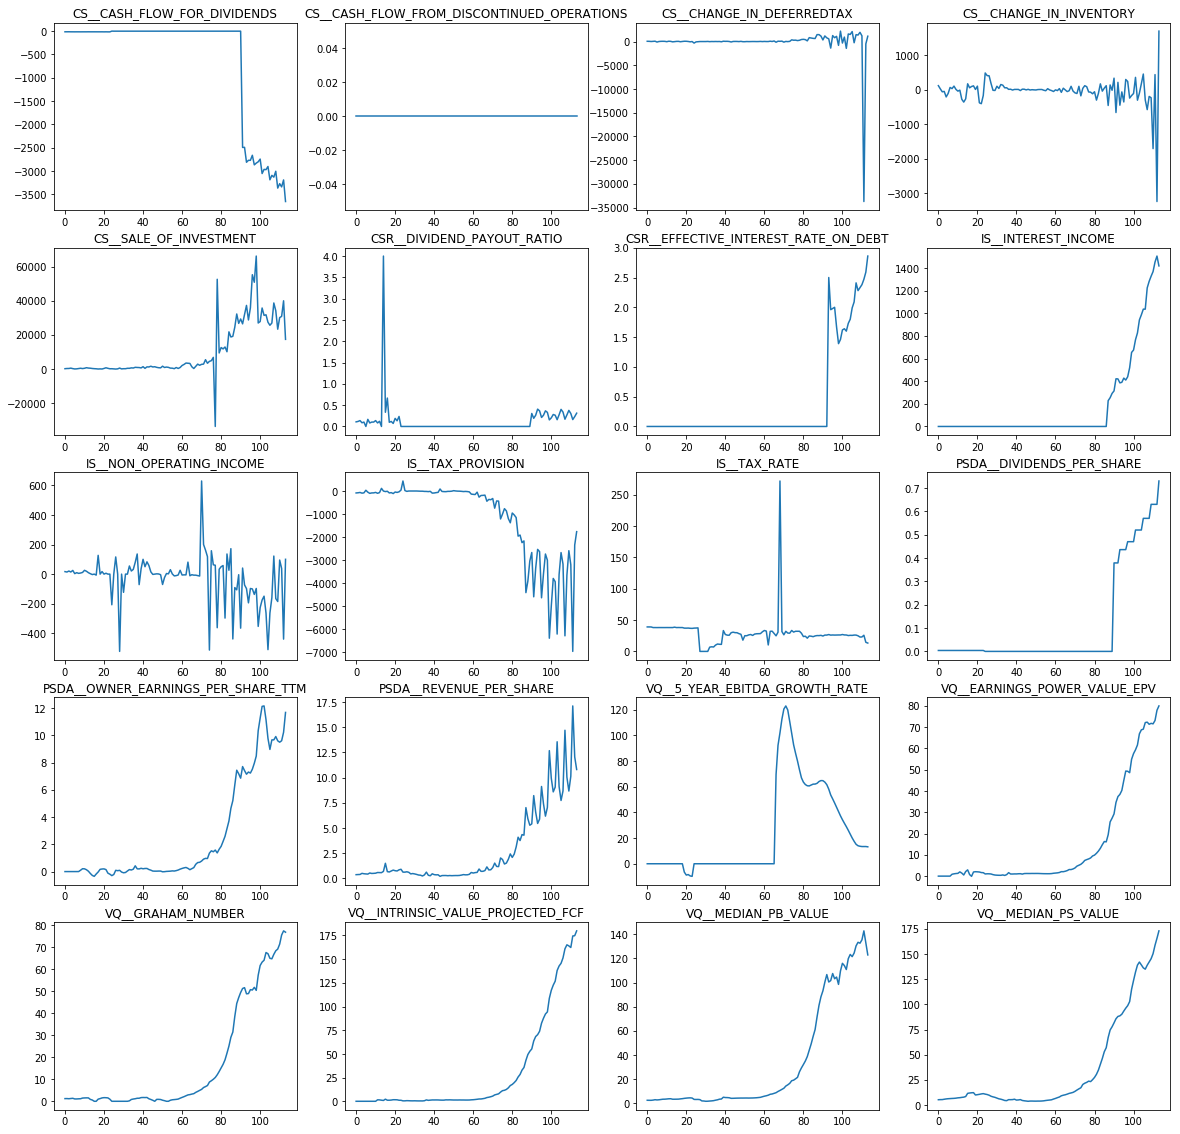

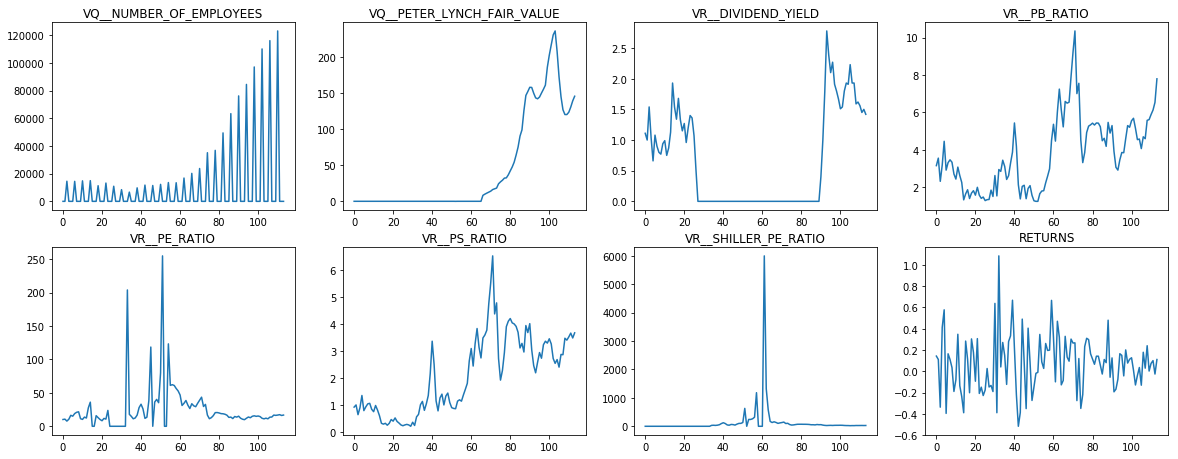

In [10]:
#APPLE
plt.clf()
i = 1
plt.figure(figsize=(20,20))
df = financialDF[financialDF['Ticker'] == 'AAPL']
cols = df.columns.drop(['Ticker','Year','Month'])
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(df[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

Vuelven a salir columnas con cero valores, las voy a quitar

In [11]:
columns_to_drop = []
dfApple = financialDF[financialDF['Ticker'] == 'AAPL']
cols = financialDF.columns.drop(['Ticker','Year', 'Month'])
for c in cols:    
    if dfApple[c].sum() == 0:         
        columns_to_drop.append(c)
dfApple.drop(columns_to_drop, axis=1, inplace=True)
dfApple.drop(['Ticker'], axis=1, inplace=True)
dfApple.shape 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(114, 29)

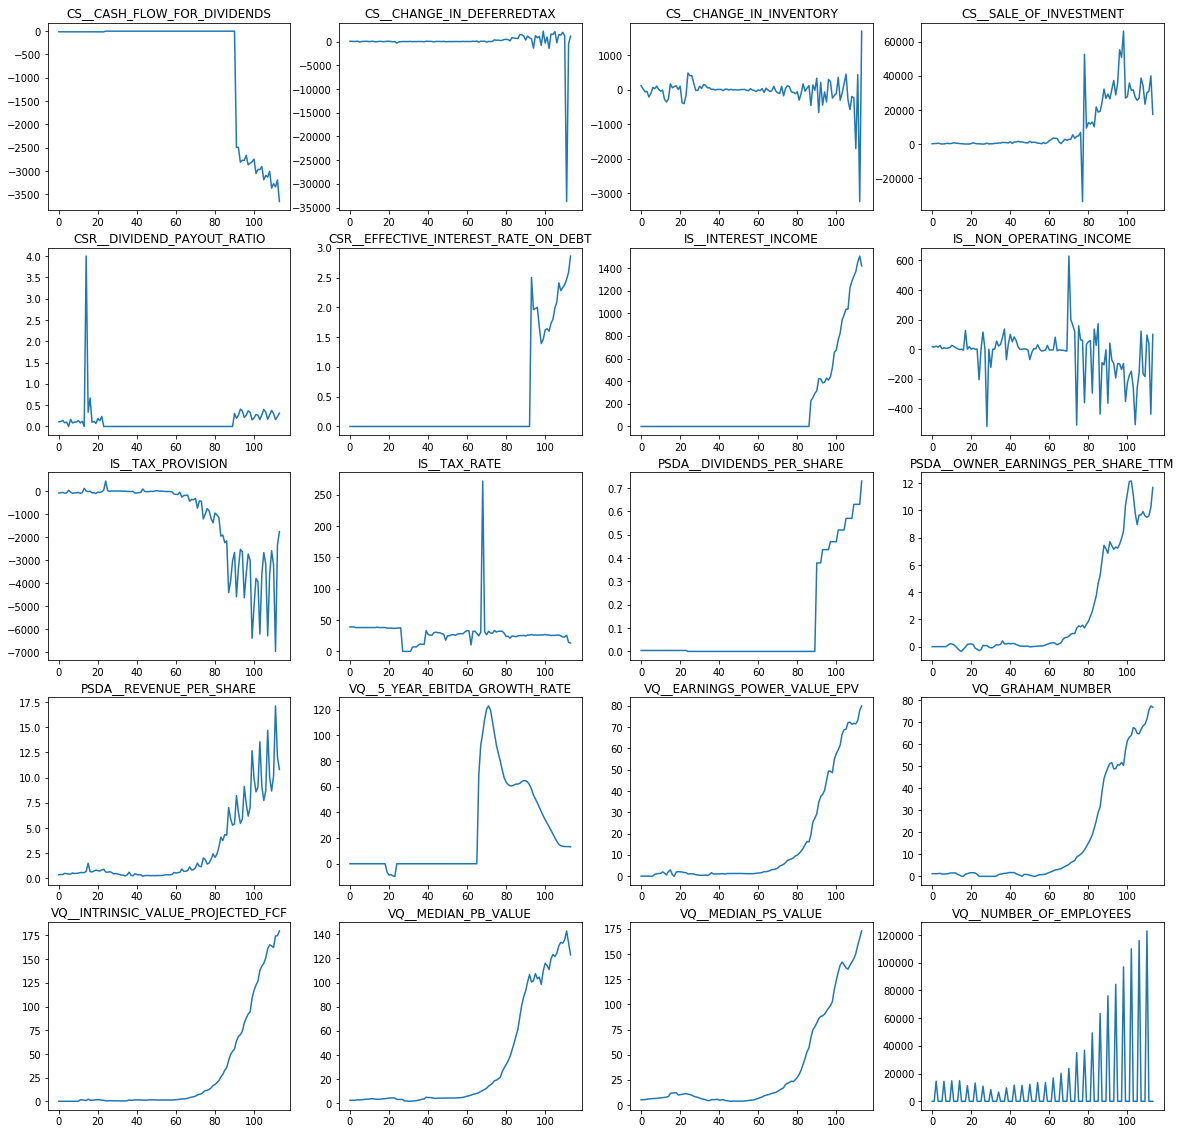

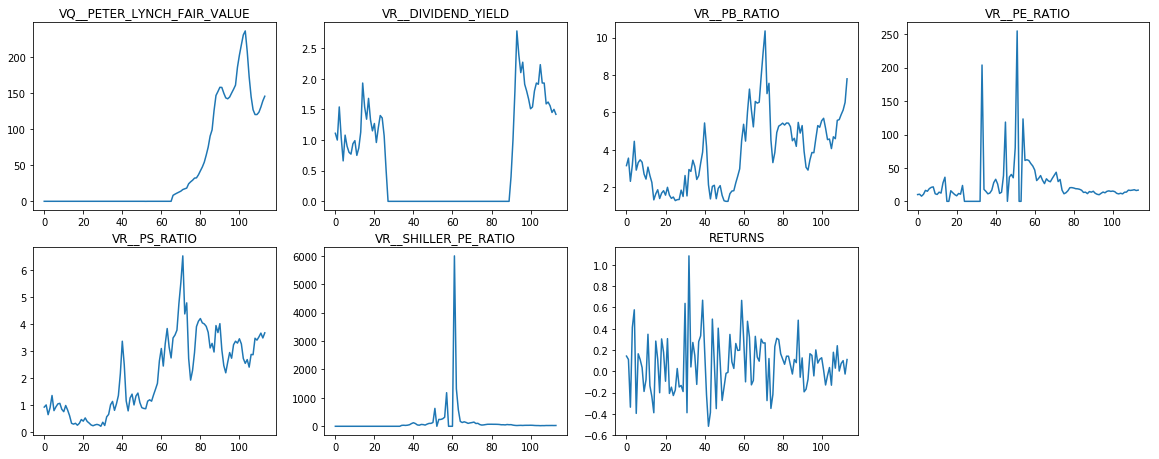

In [12]:
plt.clf()
i = 1
plt.figure(figsize=(20,20))
cols = dfApple.columns.drop(['Year','Month'])
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(dfApple[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

Vemos que hay columnas con más de un 80% de valores a cero. Voy a quitarlas también

In [13]:
columns_to_drop=['CS__CASH_FLOW_FOR_DIVIDENDS',
'CS__CHANGE_IN_DEFERREDTAX',
'CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT',
'IS__INTEREST_INCOME',
'PSDA__DIVIDENDS_PER_SHARE']
dfApple.drop(columns_to_drop, axis=1, inplace=True)
dfApple.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(114, 24)

Divido los datos en dos grupos, hasta el 2017 que lo uso para train/test y los datos del 2018 que los uso para validar los resultados.

In [14]:
dfApple['Year'] = pd.to_numeric(dfApple.Year)
dfApple_validacion = dfApple[dfApple['Year'] == 2018]
dfApple = dfApple[dfApple['Year'] < 2018]
dfApple_validacion

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,IS__NON_OPERATING_INCOME,IS__TAX_PROVISION,IS__TAX_RATE,PSDA__OWNER_EARNINGS_PER_SHARE_TTM,PSDA__REVENUE_PER_SHARE,VQ__5_YEAR_EBITDA_GROWTH_RATE,VQ__EARNINGS_POWER_VALUE_EPV,...,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS,Year,Month
53208,-3241.0,39977.0,0.231,-439.0,-2346.0,14.51,10.230,12.062,13.41,77.85,...,0.0,138.93,1.50,6.54,16.19,3.50,26.50,-0.026007,2018,03
53209,1693.0,17388.0,0.312,100.0,-1765.0,13.29,11.688,10.812,13.18,79.89,...,0.0,145.38,1.42,7.80,16.78,3.69,28.01,0.110571,2018,06


### Aumentando la cantidad de muestras

Tengo muy pocas filas, para aumentar la cantidad de datos voy a usar la librería quandl y así obtener datos mensuales

In [15]:
quandl.ApiConfig.api_key = 'XXXXXXX'
pricesAppl = quandl.get("WIKI/AAPL", start_date="1990-01-01", end_date="2017-12-31")

In [16]:
pricesAppl.reset_index(inplace=True)
pricesAppl['Month'] = pricesAppl['Date'].dt.month
pricesAppl['Year'] = pricesAppl['Date'].dt.year
pricesAppl = pricesAppl.groupby(['Year','Month']).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last'})
pricesAppl['RETURNS'] = (pricesAppl['Close'] - pricesAppl['Open']) / pricesAppl['Open']
pricesAppl.head()

Open   High    Low  Close   RETURNS
Year Month                                      
1990 1      35.25  38.75  32.13  34.00 -0.035461
     2      34.50  35.25  32.25  34.00 -0.014493
     3      33.50  43.38  33.25  40.25  0.201493
     4      40.00  44.25  38.13  39.38 -0.015500
     5      39.75  42.75  38.75  41.25  0.037736

In [17]:
pricesAppl.reset_index(inplace=True)
pricesAppl.head()

,Year,Month,Open,High,Low,Close,RETURNS
0,1990,1,35.25,38.75,32.13,34.00,-0.035461
1,1990,2,34.50,35.25,32.25,34.00,-0.014493
2,1990,3,33.50,43.38,33.25,40.25,0.201493
3,1990,4,40.00,44.25,38.13,39.38,-0.015500
4,1990,5,39.75,42.75,38.75,41.25,0.037736


In [18]:
dfApple['Month'] = pd.to_numeric(dfApple.Month)
dfApple = pricesAppl.set_index(['Year','Month']).join(dfApple.set_index(['Year','Month']), lsuffix='_prices', rsuffix='_fin')
dfApple = dfApple.interpolate(method='linear')
dfApple = dfApple.dropna()
dfApple.head()

Open   High    Low  Close  RETURNS_prices  \
Year Month                                               
1990 3      33.50  43.38  33.25  40.25        0.201493   
     4      40.00  44.25  38.13  39.38       -0.015500   
     5      39.75  42.75  38.75  41.25        0.037736   
     6      41.38  44.88  37.50  44.75        0.081440   
     7      44.50  47.75  40.00  42.00       -0.056180   

            CS__CHANGE_IN_INVENTORY  CS__SALE_OF_INVESTMENT  \
Year Month                                                    
1990 3                   114.100000              206.500000   
     4                    82.933333              242.500000   
     5                    51.766667              278.500000   
     6                    20.600000              314.500000   
     7                    -7.466667              320.833333   

            CSR__DIVIDEND_PAYOUT_RATIO  IS__NON_OPERATING_INCOME  \
Year Month                                                         
1990 3                        0.108000                 16.900000   
     4                        0.111333                 15.966667   
     5                        0.114667                 15.033333   
     6                        0.118000                 14.100000   
     7                        0.124667                 16.366667   

            IS__TAX_PROVISION     ...       VQ__MEDIAN_PB_VALUE  \
Year Month                        ...                             
1990 3             -84.300000     ...                  2.360000   
     4             -81.733333     ...                  2.350000   
     5             -79.166667     ...                  2.340000   
     6             -76.600000     ...                  2.330000   
     7             -72.033333     ...                  2.326667   

            VQ__MEDIAN_PS_VALUE  VQ__NUMBER_OF_EMPLOYEES  \
Year Month                                                 
1990 3                 5.310000                      0.0   
     4                 5.346667                      0.0   
     5                 5.383333                      0.0   
     6                 5.420000                      0.0   
     7                 5.430000                   4839.0   

            VQ__PETER_LYNCH_FAIR_VALUE  VR__DIVIDEND_YIELD  VR__PB_RATIO  \
Year Month                                                                 
1990 3                             0.0            1.110000      3.160000   
     4                             0.0            1.073333      3.293333   
     5                             0.0            1.036667      3.426667   
     6                             0.0            1.000000      3.560000   
     7                             0.0            1.180000      3.146667   

            VR__PE_RATIO  VR__PS_RATIO  VR__SHILLER_PE_RATIO  RETURNS_fin  
Year Month                                                                 
1990 3         10.140000      0.940000                   0.0     0.142857  
     4         10.316667      0.966667                   0.0     0.132275  
     5         10.493333      0.993333                   0.0     0.121693  
     6         10.670000      1.020000                   0.0     0.111111  
     7          9.700000      0.900000                   0.0    -0.038452  

[5 rows x 27 columns]

### Persistence model

In [19]:
# persistence model
def model_persistence(x):
    return x

In [20]:
def create_model(serie, split_value):
    # create lagged dataset
    values = pd.DataFrame(serie.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t', 't+1']
    # split into train and test sets
    X = dataframe.values
    limite = int(len(X)*split_value)
    if split_value == 1:
        limite = 1
    train, test = X[1:len(X)-limite], X[len(X)-limite:]    
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
    rmse = sqrt(mean_squared_error(test_y, predictions))
    return test_y,predictions,rmse    

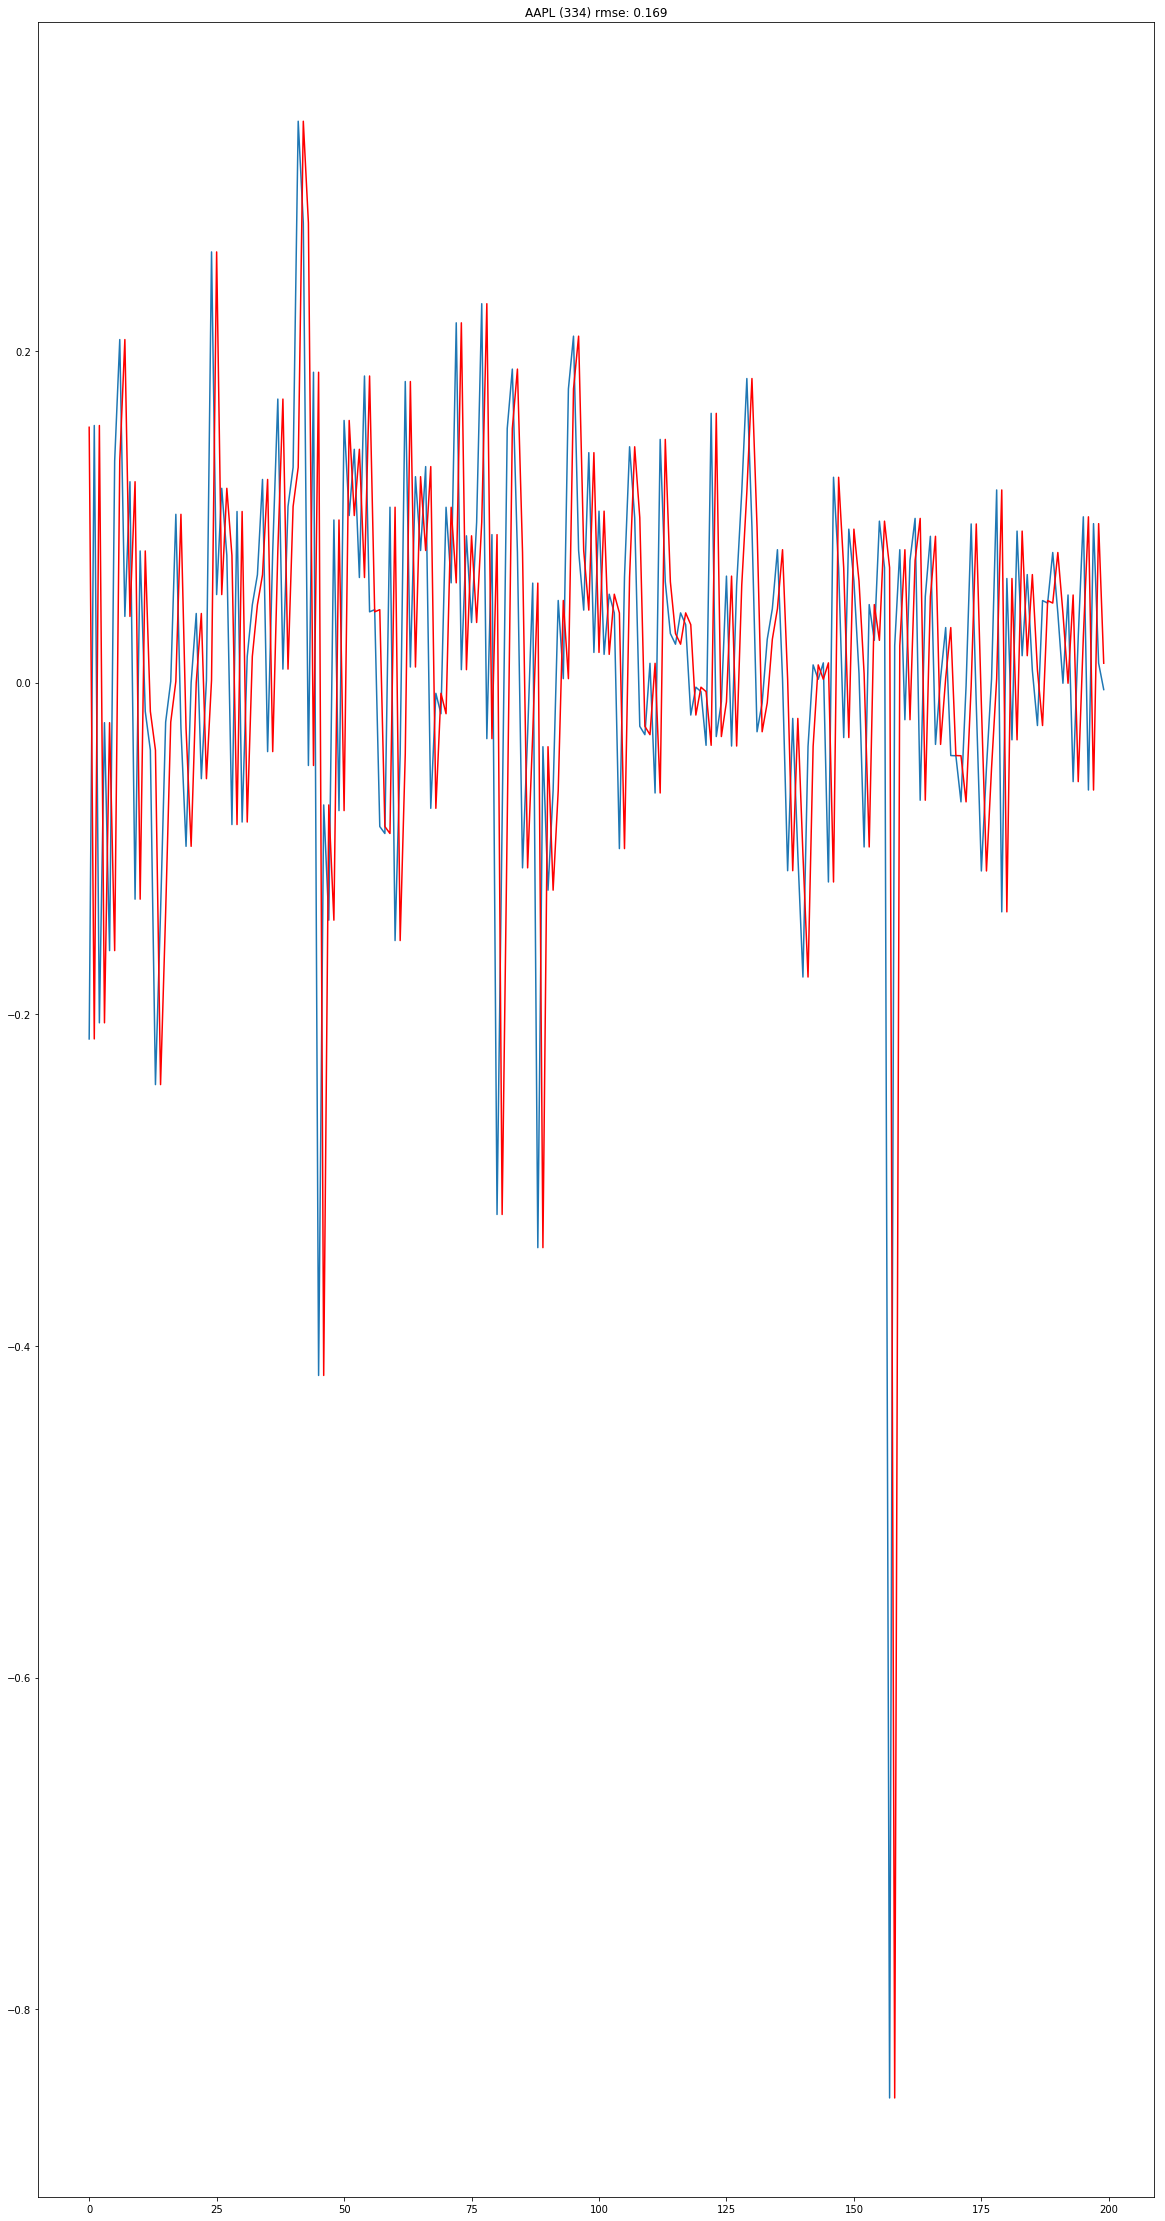

In [21]:
plt.clf()
i = 1
plt.figure(figsize=(20,40))
persistence_model = list()
#for c in lista_companyas_def:    
#plt.subplot(4, 5, i)
group = dfApple.loc[:,'RETURNS_prices']
test_y,predictions,rmse = create_model(group, 0.6)
strRmse = ') rmse: %.3f'%rmse
title = 'AAPL (' + str(len(group)) + strRmse
plt.title(title)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')

In [22]:
#Predigo solo el último valor, es decir, para el 2017 devuelvo lo mismo que obtuve en 2016
#El rmse será el error producido entre el valor real de 2017 y el que se devolvió (valor a 2016)
#Esto me va a servir para comparar este modelo con el resto
persistence_model = list()
#for code, group in seriePorSimbolo:    
test_y,predictions,rmse = create_model(group, 1)                                                     
#persistence_model.append({'code': code, 'prediction':predictions, 'rmse': rmse})

### VAR (Vector Auto Regression)

Partiendo del modelo anterior, vamos a aplicar distintos algoritmos que lo mejoren. El primero de ellos será VAR.

In [23]:
dfApple.reset_index(inplace=True)
dfApple['Year'] = dfApple['Year'].apply(lambda x: str(x))
dfApple['Month'] = dfApple['Month'].apply(lambda x: str(x).zfill(2))
dfApple['Date'] = (dfApple['Year']) + str('-') + (dfApple['Month'])
dfApple['Date'] = pd.to_datetime(dfApple['Date'])
dfApple.set_index('Date', inplace=True)
dfApple.head()

,Year,Month,Open,High,Low,Close,RETURNS_prices,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,...,VQ__MEDIAN_PB_VALUE,VQ__MEDIAN_PS_VALUE,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS_fin
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-01,1990,03,33.50,43.38,33.25,40.25,0.201493,114.100000,206.500000,0.108000,...,2.360000,5.310000,0.0,0.0,1.110000,3.160000,10.140000,0.940000,0.0,0.142857
1990-04-01,1990,04,40.00,44.25,38.13,39.38,-0.015500,82.933333,242.500000,0.111333,...,2.350000,5.346667,0.0,0.0,1.073333,3.293333,10.316667,0.966667,0.0,0.132275
1990-05-01,1990,05,39.75,42.75,38.75,41.25,0.037736,51.766667,278.500000,0.114667,...,2.340000,5.383333,0.0,0.0,1.036667,3.426667,10.493333,0.993333,0.0,0.121693
1990-06-01,1990,06,41.38,44.88,37.50,44.75,0.081440,20.600000,314.500000,0.118000,...,2.330000,5.420000,0.0,0.0,1.000000,3.560000,10.670000,1.020000,0.0,0.111111
1990-07-01,1990,07,44.50,47.75,40.00,42.00,-0.056180,-7.466667,320.833333,0.124667,...,2.326667,5.430000,4839.0,0.0,1.180000,3.146667,9.700000,0.900000,0.0,-0.038452


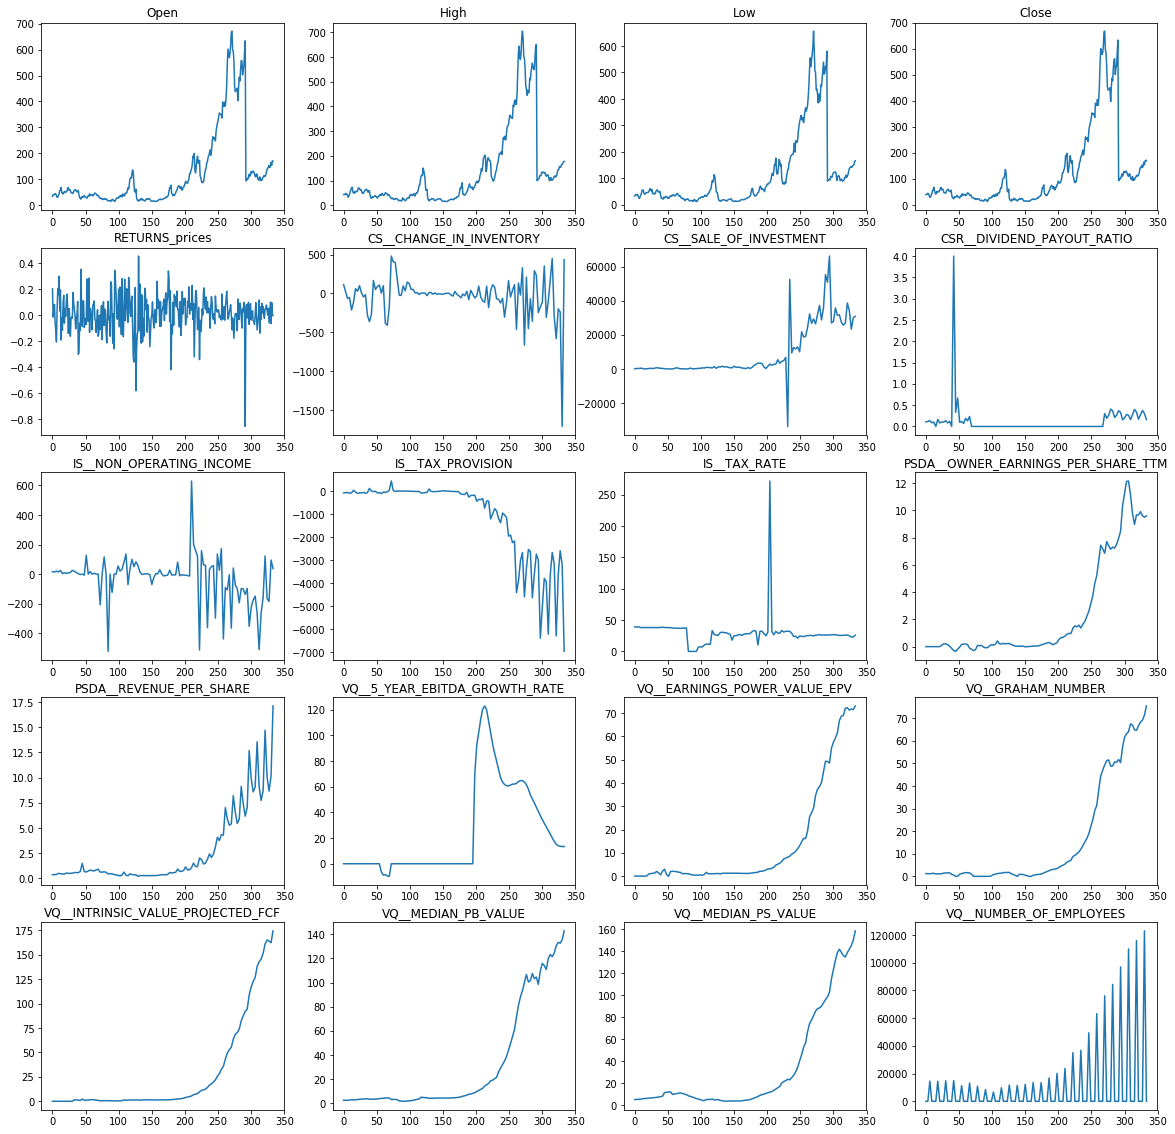

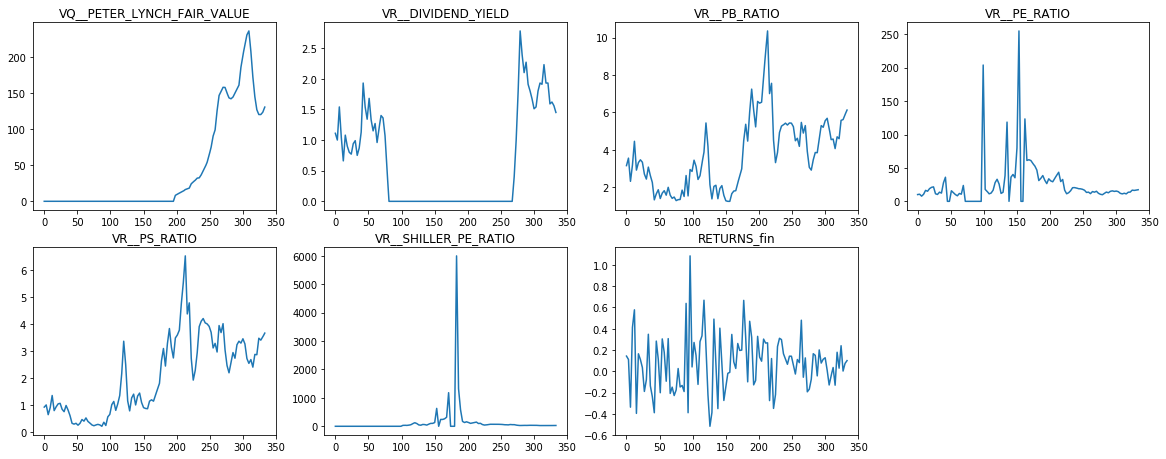

In [24]:
dfApple.drop(['Year','Month'], axis=1, inplace=True)
plt.clf()
i = 1
plt.figure(figsize=(20,20))
cols = dfApple.columns
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(dfApple[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

In [25]:
from statsmodels.tsa.vector_ar.var_model import VAR

#creating the train and validation set
train = dfApple[:int(0.8*(len(dfApple)))]
valid = dfApple[int(0.8*(len(dfApple))):]

#fit the model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation    
p = model_fit.forecast(model_fit.y, steps=len(valid))
#predictions.append({'codigo':c, 'prediction':p, 'valid': valid})


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [26]:
cols = dfApple.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(p)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(p)):
        pred.iloc[i][j] = p[i][j]
    #check rmse
try:
    rmse_var = sqrt(mean_squared_error(pred['RETURNS_prices'], valid['RETURNS_prices']))
    print('rmse(VAR) value for RETURNS is:', rmse_var, 'vs rmse(base)',rmse)      
except:
    pass

rmse(VAR) value for RETURNS is: 0.5903359408916066 vs rmse(base) 0.015892512372916223


Con los datos disponibles no hemos podido realizar una predicción. Vamos con la siguiente empresa

### ABT

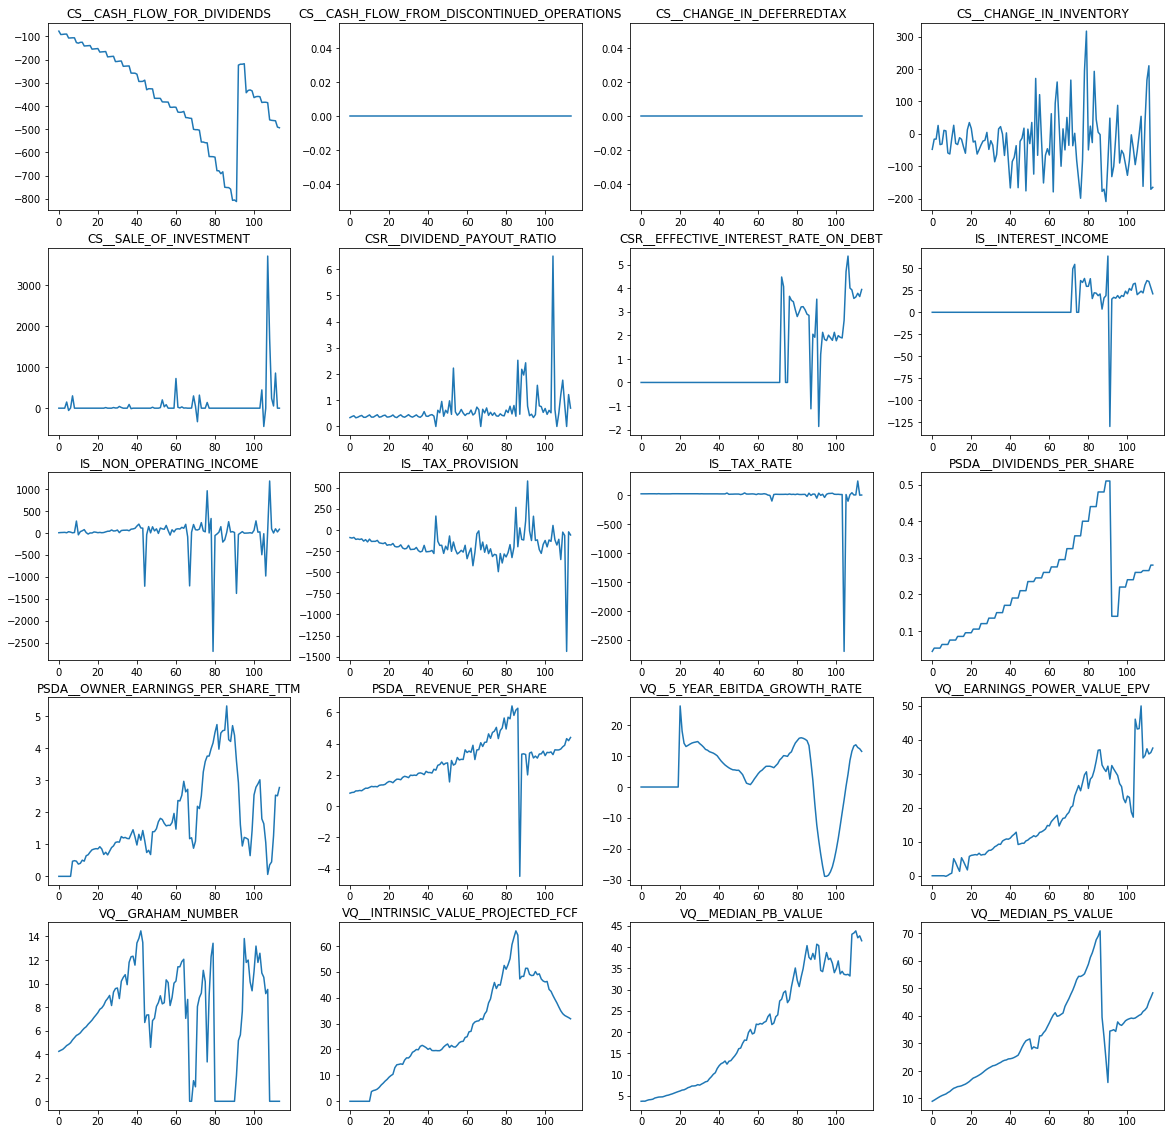

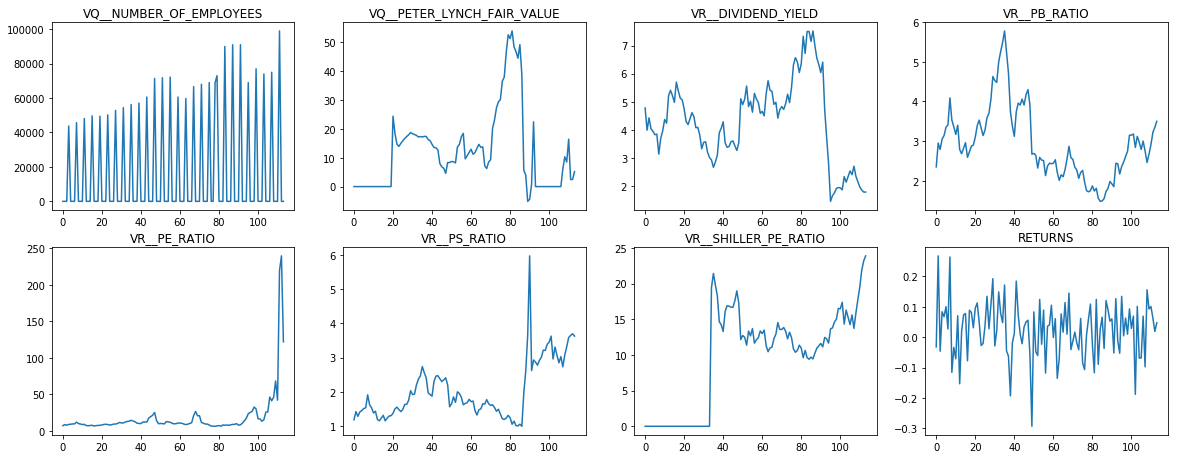

In [27]:
#ABT
plt.clf()
i = 1
plt.figure(figsize=(20,20))
df = financialDF[financialDF['Ticker'] == 'ABT']
cols = df.columns.drop(['Ticker','Year','Month'])
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(df[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

Vuelven a salir columnas a cero, las voy a quitar

In [28]:
columns_to_drop = []
dfAbt = financialDF[financialDF['Ticker'] == 'ABT']
cols = dfAbt.columns.drop(['Ticker','Year', 'Month'])
for c in cols:    
    if dfAbt[c].sum() == 0:         
        columns_to_drop.append(c)
dfAbt.drop(columns_to_drop, axis=1, inplace=True)
dfAbt.drop(['Ticker'], axis=1, inplace=True)
dfAbt.shape 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(114, 28)

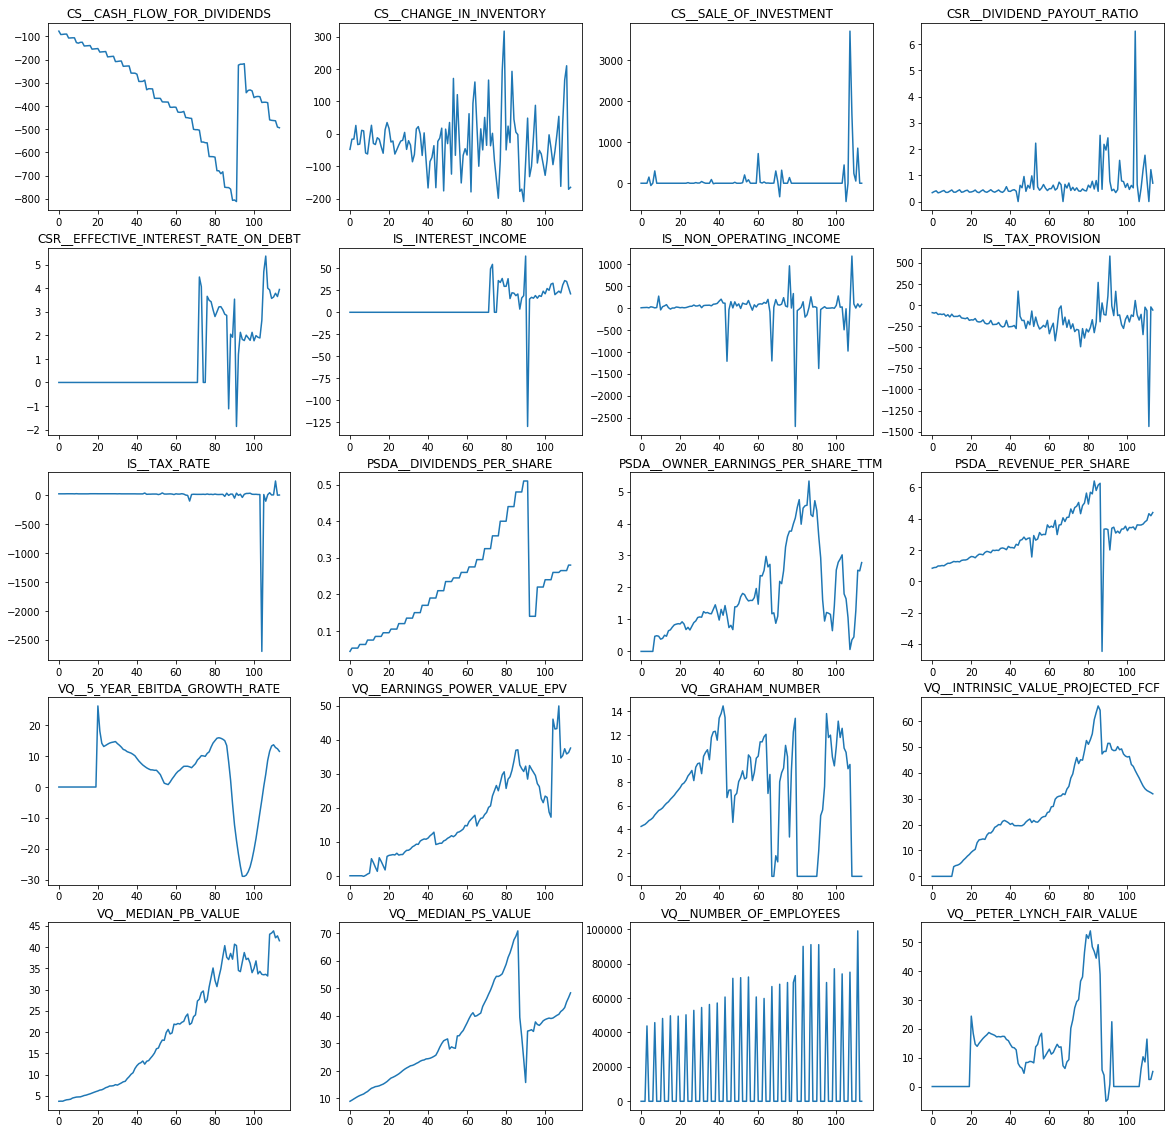

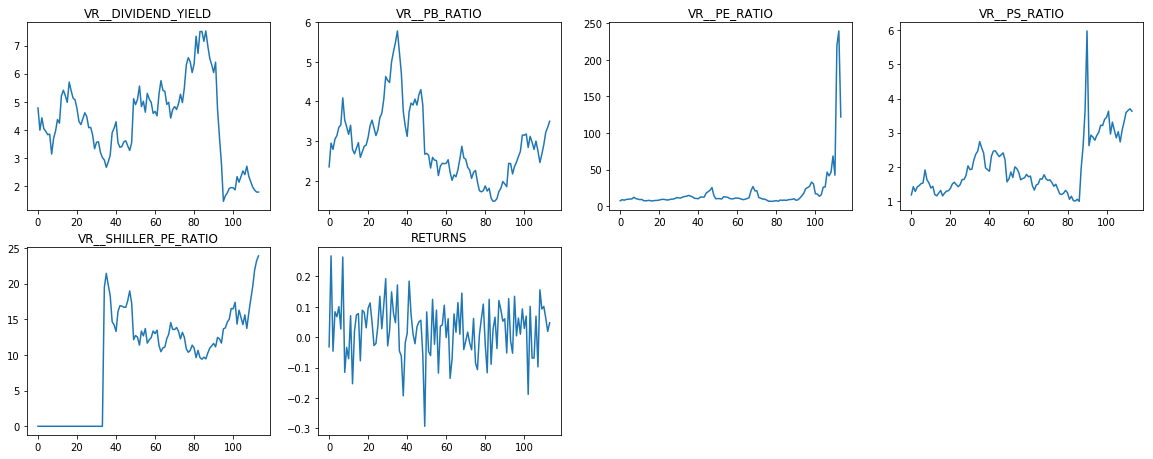

In [29]:
plt.clf()
i = 1
plt.figure(figsize=(20,20))
cols = dfAbt.columns.drop(['Year','Month'])
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(dfAbt[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

In [30]:
dfAbt['Year'] = pd.to_numeric(dfAbt.Year)
dfAbt_validacion = dfAbt[dfAbt['Year'] == 2018]
dfAbt = dfAbt[dfAbt['Year'] < 2018]
dfAbt_validacion

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT,IS__INTEREST_INCOME,IS__NON_OPERATING_INCOME,IS__TAX_PROVISION,IS__TAX_RATE,PSDA__DIVIDENDS_PER_SHARE,...,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS,Year,Month
55100,-491.0,-171.0,0.0,1.217,3.65,28.0,22.0,-22.0,5.10,0.28,...,0.0,2.48,1.79,3.35,239.68,3.70,23.2,0.019221,2018,03
55101,-494.0,-165.0,0.0,0.700,3.95,21.0,84.0,-59.0,7.59,0.28,...,0.0,5.20,1.79,3.50,121.98,3.63,23.9,0.047758,2018,06


### Aumentando la cantidad de muestras

In [31]:
pricesAbt = quandl.get("WIKI/ABT", start_date="1990-01-01", end_date="2017-12-31")
pricesAbt.reset_index(inplace=True)
pricesAbt.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,1990-01-02,68.25,69.25,68.00,69.25,1263275.0,0.00,1.0,2.000662,2.029976,1.993334,2.029976,10106200.0
1,1990-01-03,69.37,69.75,69.00,69.50,764300.0,0.00,1.0,2.033493,2.044633,2.022647,2.037304,6114400.0
2,1990-01-04,69.63,69.75,68.75,69.37,809525.0,0.00,1.0,2.041115,2.044633,2.015319,2.033493,6476200.0
3,1990-01-05,69.12,69.25,68.38,68.63,422800.0,0.00,1.0,2.026165,2.029976,2.004473,2.011801,3382400.0
4,1990-01-08,68.00,68.75,67.75,68.63,828913.0,0.35,1.0,2.003499,2.025597,1.996133,2.022061,6631304.0


In [32]:
pricesAbt['Month'] = pricesAbt['Date'].dt.month
pricesAbt['Year'] = pricesAbt['Date'].dt.year
pricesAbt = pricesAbt.groupby(['Year','Month']).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last'})
pricesAbt['RETURNS'] = (pricesAbt['Close'] - pricesAbt['Open']) / pricesAbt['Open']
pricesAbt.head()

Open   High    Low  Close   RETURNS
Year Month                                      
1990 1      68.25  69.75  63.50  65.00 -0.047619
     2      65.00  66.25  62.50  64.12 -0.013538
     3      64.00  66.00  62.75  65.75  0.027344
     4      65.50  69.75  65.25  66.75  0.019084
     5      67.00  74.87  66.75  74.87  0.117463

In [33]:
pricesAbt.reset_index(inplace=True)
dfAbt['Month'] = pd.to_numeric(dfAbt.Month)
dfAbt = pricesAbt.set_index(['Year','Month']).join(dfAbt.set_index(['Year','Month']), lsuffix='_prices', rsuffix='_fin')
dfAbt = dfAbt.interpolate(method='linear')
dfAbt = dfAbt.dropna()
dfAbt.head()

Open   High    Low  Close  RETURNS_prices  \
Year Month                                              
1990 3      64.0  66.00  62.75  65.75        0.027344   
     4      65.5  69.75  65.25  66.75        0.019084   
     5      67.0  74.87  66.75  74.87        0.117463   
     6      38.0  42.13  37.00  41.00        0.078947   
     7      41.0  45.63  40.50  43.50        0.060976   

            CS__CASH_FLOW_FOR_DIVIDENDS  CS__CHANGE_IN_INVENTORY  \
Year Month                                                         
1990 3                       -77.400000               -47.900000   
     4                       -82.300000               -37.433333   
     5                       -87.200000               -26.966667   
     6                       -92.100000               -16.500000   
     7                       -91.866667               -16.400000   

            CS__SALE_OF_INVESTMENT  CSR__DIVIDEND_PAYOUT_RATIO  \
Year Month                                                       
1990 3                         0.0                    0.338000   
     4                         0.0                    0.351667   
     5                         0.0                    0.365333   
     6                         0.0                    0.379000   
     7                         0.0                    0.388667   

            CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT     ...       \
Year Month                                           ...        
1990 3                                       0.0     ...        
     4                                       0.0     ...        
     5                                       0.0     ...        
     6                                       0.0     ...        
     7                                       0.0     ...        

            VQ__MEDIAN_PB_VALUE  VQ__MEDIAN_PS_VALUE  VQ__NUMBER_OF_EMPLOYEES  \
Year Month                                                                      
1990 3                 3.720000             8.980000                      0.0   
     4                 3.730000             9.116667                      0.0   
     5                 3.740000             9.253333                      0.0   
     6                 3.750000             9.390000                      0.0   
     7                 3.746667             9.540000                      0.0   

            VQ__PETER_LYNCH_FAIR_VALUE  VR__DIVIDEND_YIELD  VR__PB_RATIO  \
Year Month                                                                 
1990 3                             0.0            4.780000      2.350000   
     4                             0.0            4.516667      2.550000   
     5                             0.0            4.253333      2.750000   
     6                             0.0            3.990000      2.950000   
     7                             0.0            4.136667      2.896667   

            VR__PE_RATIO  VR__PS_RATIO  VR__SHILLER_PE_RATIO  RETURNS_fin  
Year Month                                                                 
1990 3          7.220000      1.180000                   0.0    -0.031579  
     4          7.730000      1.260000                   0.0     0.068201  
     5          8.240000      1.340000                   0.0     0.167980  
     6          8.750000      1.420000                   0.0     0.267760  
     7          8.486667      1.373333                   0.0     0.163256  

[5 rows x 31 columns]

In [34]:
dfAbt.reset_index(inplace=True)
dfAbt['Year'] = dfAbt['Year'].apply(lambda x: str(x))
dfAbt['Month'] = dfAbt['Month'].apply(lambda x: str(x).zfill(2))
dfAbt['Date'] = (dfAbt['Year']) + str('-') + (dfAbt['Month'])
dfAbt['Date'] = pd.to_datetime(dfAbt['Date'])
dfAbt.set_index('Date', inplace=True)
dfAbt.head()

,Year,Month,Open,High,Low,Close,RETURNS_prices,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,...,VQ__MEDIAN_PB_VALUE,VQ__MEDIAN_PS_VALUE,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS_fin
Date,,,,,,,,,,,,,,,,,,,,,
1990-03-01,1990,03,64.0,66.00,62.75,65.75,0.027344,-77.400000,-47.900000,0.0,...,3.720000,8.980000,0.0,0.0,4.780000,2.350000,7.220000,1.180000,0.0,-0.031579
1990-04-01,1990,04,65.5,69.75,65.25,66.75,0.019084,-82.300000,-37.433333,0.0,...,3.730000,9.116667,0.0,0.0,4.516667,2.550000,7.730000,1.260000,0.0,0.068201
1990-05-01,1990,05,67.0,74.87,66.75,74.87,0.117463,-87.200000,-26.966667,0.0,...,3.740000,9.253333,0.0,0.0,4.253333,2.750000,8.240000,1.340000,0.0,0.167980
1990-06-01,1990,06,38.0,42.13,37.00,41.00,0.078947,-92.100000,-16.500000,0.0,...,3.750000,9.390000,0.0,0.0,3.990000,2.950000,8.750000,1.420000,0.0,0.267760
1990-07-01,1990,07,41.0,45.63,40.50,43.50,0.060976,-91.866667,-16.400000,0.0,...,3.746667,9.540000,0.0,0.0,4.136667,2.896667,8.486667,1.373333,0.0,0.163256


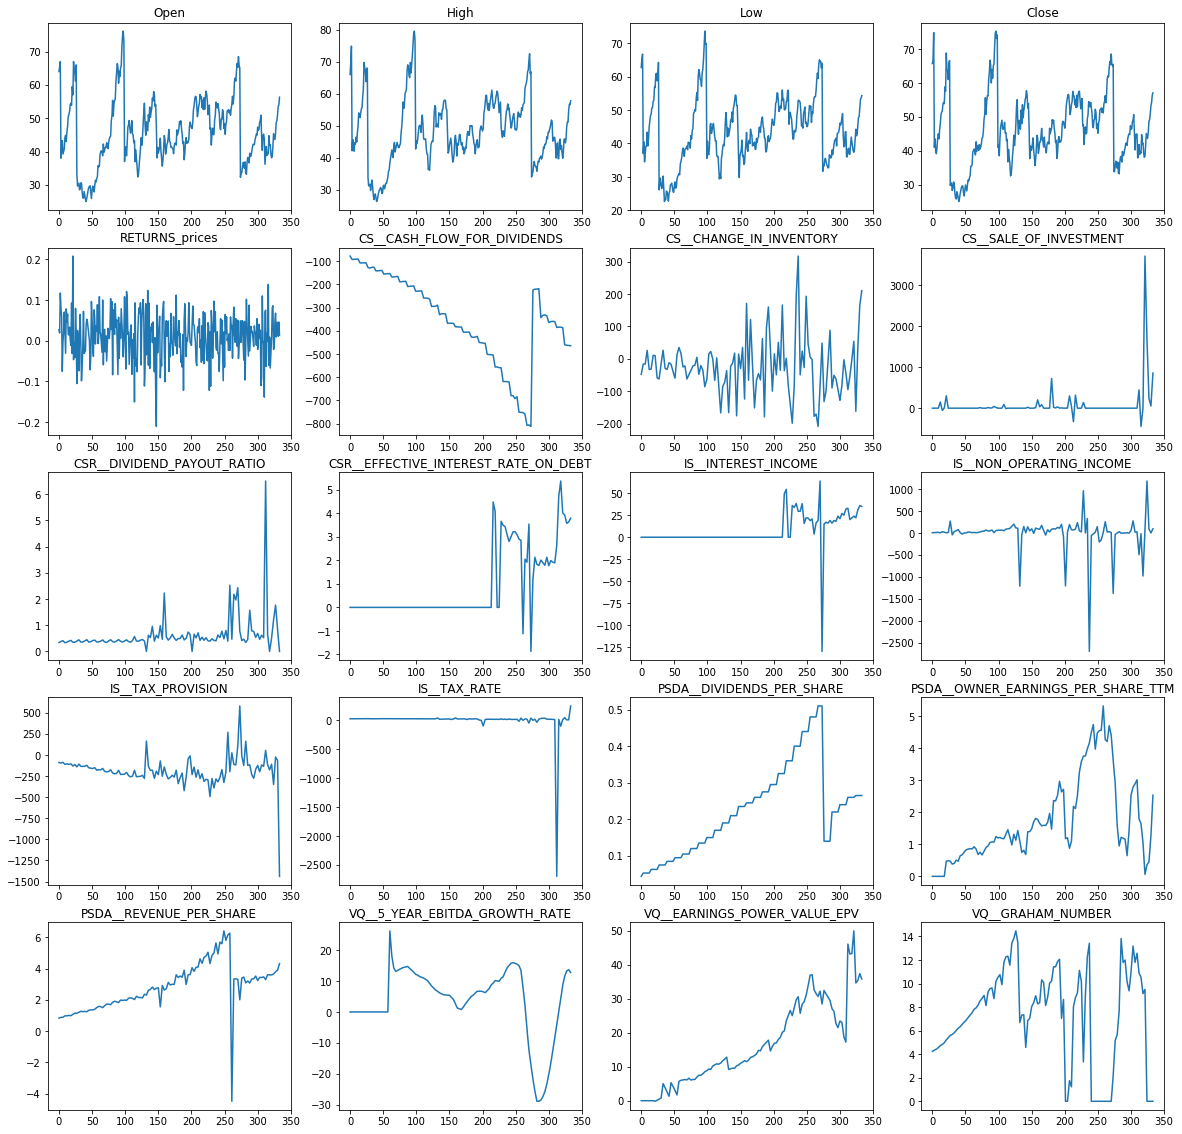

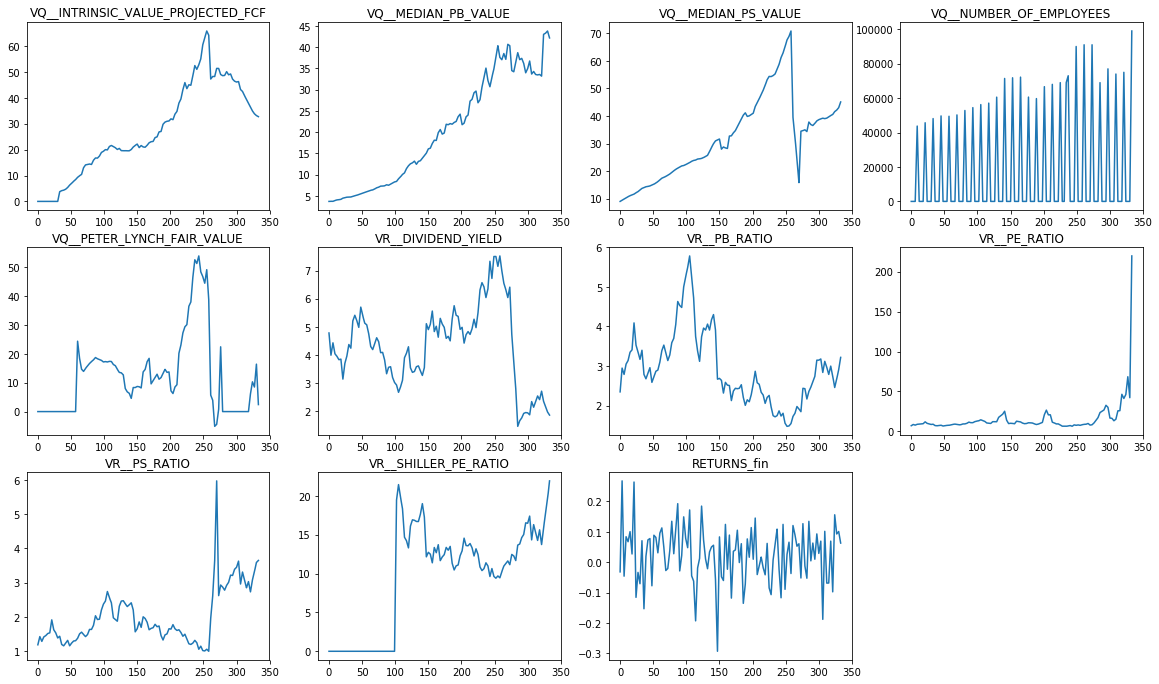

In [35]:
dfAbt.drop(['Year','Month'], axis=1, inplace=True)
plt.clf()
i = 1
plt.figure(figsize=(20,20))
cols = dfAbt.columns
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(dfAbt[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

### Persistence model

In [36]:
#Predigo solo el último valor, es decir, para el 2017 devuelvo lo mismo que obtuve en 2016
#El rmse será el error producido entre el valor real de 2017 y el que se devolvió (valor a 2016)
#Esto me va a servir para comparar este modelo con el resto
persistence_model = list()
group = dfAbt.loc[:,'RETURNS_prices']
test_y,predictions,rmse_abt = create_model(group, 1)                                                     
#persistence_model.append({'code': code, 'prediction':predictions, 'rmse': rmse})

In [37]:
from statsmodels.tsa.vector_ar.var_model import VAR

#creating the train and validation set
train = dfAbt[:int(0.8*(len(dfAbt)))]
valid = dfAbt[int(0.8*(len(dfAbt))):]

#fit the model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation    
p = model_fit.forecast(model_fit.y, steps=len(valid))
#predictions.append({'codigo':c, 'prediction':p, 'valid': valid})

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [38]:
cols = dfApple.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(p)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(p)):
        pred.iloc[i][j] = p[i][j]
    #check rmse
try:
    rmse_var = sqrt(mean_squared_error(pred['RETURNS_prices'], valid['RETURNS_prices']))
    print('rmse(VAR) value for RETURNS is:', rmse_var, 'vs rmse(base)',rmse_abt)      
except:
    pass

rmse(VAR) value for RETURNS is: 0.08468010029711102 vs rmse(base) 0.03234293790357097


De nuevo los resultados son peores que el modelo base

### DVN

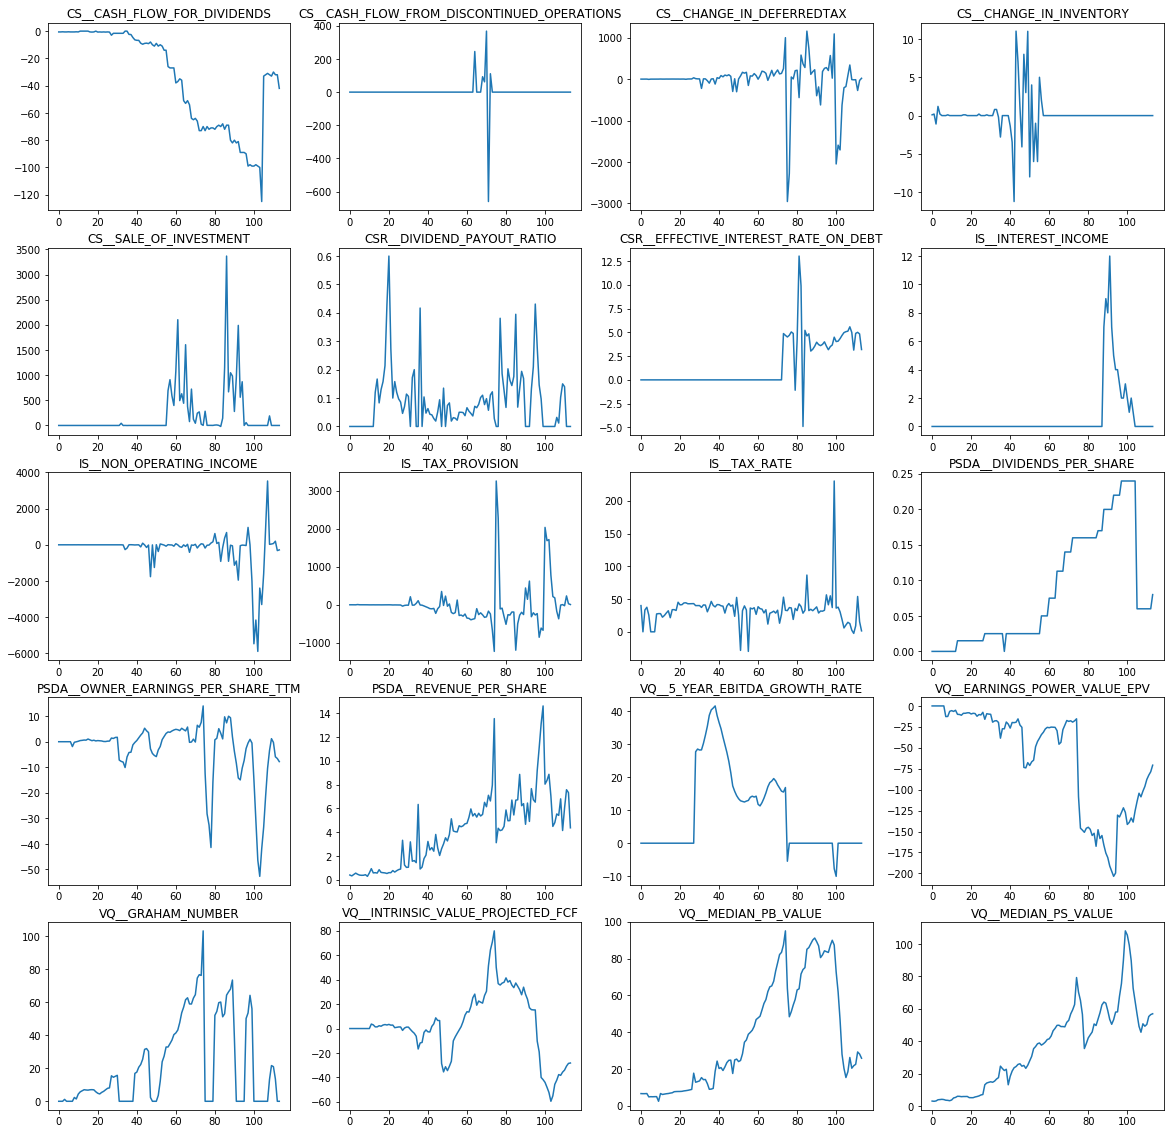

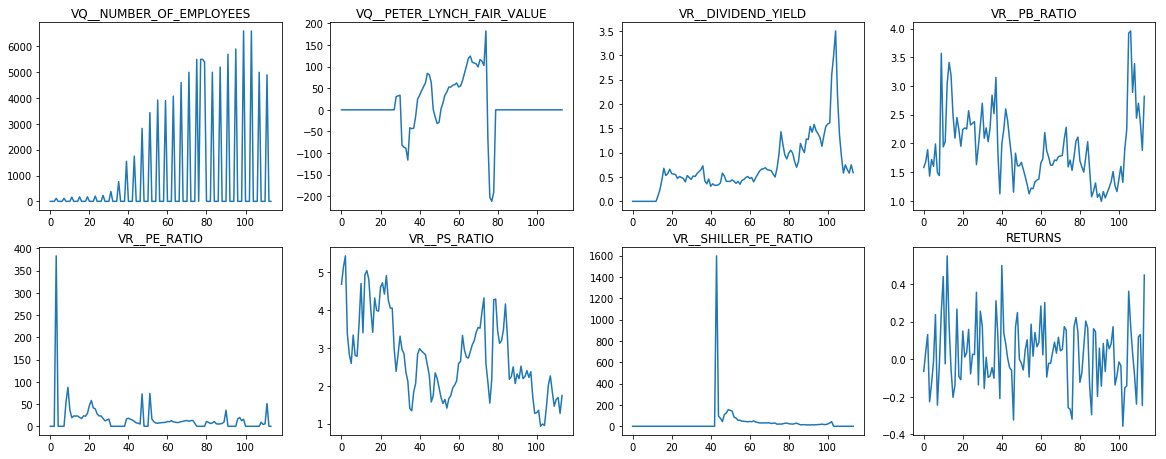

In [39]:
#DVN
plt.clf()
i = 1
plt.figure(figsize=(20,20))
df = financialDF[financialDF['Ticker'] == 'DVN']
cols = df.columns.drop(['Ticker','Year','Month'])
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(df[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

Vuelven a salir columnas a cero, las quitamos

In [41]:
columns_to_drop = []
dfDvn = financialDF[financialDF['Ticker'] == 'DVN']
cols = dfDvn.columns.drop(['Ticker','Year', 'Month'])
for c in cols:    
    if dfDvn[c].sum() == 0:         
        columns_to_drop.append(c)
dfDvn.drop(columns_to_drop, axis=1, inplace=True)
dfDvn.drop(['Ticker'], axis=1, inplace=True)
dfDvn.shape 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(114, 30)

In [42]:
dfDvn['Year'] = pd.to_numeric(dfDvn.Year)
dfDvn_validacion = dfDvn[dfDvn['Year'] == 2018]
dfDvn = dfDvn[dfDvn['Year'] < 2018]
dfDvn_validacion

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS,CS__CHANGE_IN_DEFERREDTAX,CS__CHANGE_IN_INVENTORY,CS__SALE_OF_INVESTMENT,CSR__DIVIDEND_PAYOUT_RATIO,CSR__EFFECTIVE_INTEREST_RATE_ON_DEBT,IS__INTEREST_INCOME,IS__NON_OPERATING_INCOME,IS__TAX_PROVISION,...,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS,Year,Month
153320,-32.0,0.0,-32.0,0.0,0.0,0.0,4.83,0.0,-319.0,28.0,...,0.0,0.0,0.75,1.88,0.0,1.27,0.0,-0.247218,2018,03
153321,-42.0,0.0,20.0,0.0,0.0,0.0,3.19,0.0,-281.0,7.0,...,0.0,0.0,0.59,2.82,0.0,1.74,0.0,0.448435,2018,06


### Aumentando la cantidad de muestras

In [43]:
pricesDvn = quandl.get("WIKI/DVN", start_date="1990-01-01", end_date="2017-12-31")
pricesDvn.reset_index(inplace=True)
pricesDvn.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,1992-03-17,9.000,9.000,8.750,8.875,15600.0,0.0,1.0,3.686090,3.686090,3.583698,3.634894,31200.0
1,1992-03-18,8.875,8.875,8.875,8.875,100.0,0.0,1.0,3.634894,3.634894,3.634894,3.634894,200.0
2,1992-03-19,8.750,8.750,8.625,8.625,5000.0,0.0,1.0,3.583698,3.583698,3.532503,3.532503,10000.0
3,1992-03-20,8.625,8.625,8.625,8.625,700.0,0.0,1.0,3.532503,3.532503,3.532503,3.532503,1400.0
4,1992-03-23,8.625,8.750,8.625,8.750,5100.0,0.0,1.0,3.532503,3.583698,3.532503,3.583698,10200.0


In [44]:
pricesDvn['Month'] = pricesDvn['Date'].dt.month
pricesDvn['Year'] = pricesDvn['Date'].dt.year
pricesDvn = pricesDvn.groupby(['Year','Month']).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last'})
pricesDvn['RETURNS'] = (pricesDvn['Close'] - pricesDvn['Open']) / pricesDvn['Open']
pricesDvn.head()

Open    High     Low   Close   RETURNS
Year Month                                          
1992 3       9.000   9.125   8.500   8.625 -0.041667
     4       8.375   9.000   7.875   9.000  0.074627
     5       9.000  11.250   9.000  11.000  0.222222
     6      10.880  11.000   9.750  10.500 -0.034926
     7      10.500  13.880  10.500  13.750  0.309524

In [45]:
pricesDvn.reset_index(inplace=True)
dfDvn['Month'] = pd.to_numeric(dfDvn.Month)
dfDvn = pricesDvn.set_index(['Year','Month']).join(dfDvn.set_index(['Year','Month']), lsuffix='_prices', rsuffix='_fin')
dfDvn = dfDvn.interpolate(method='linear')
dfDvn = dfDvn.dropna()
dfDvn.head()

Open    High     Low   Close  RETURNS_prices  \
Year Month                                                   
1992 3       9.000   9.125   8.500   8.625       -0.041667   
     4       8.375   9.000   7.875   9.000        0.074627   
     5       9.000  11.250   9.000  11.000        0.222222   
     6      10.880  11.000   9.750  10.500       -0.034926   
     7      10.500  13.880  10.500  13.750        0.309524   

            CS__CASH_FLOW_FOR_DIVIDENDS  \
Year Month                                
1992 3                        -0.600000   
     4                        -0.566667   
     5                        -0.533333   
     6                        -0.500000   
     7                        -0.533333   

            CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS  \
Year Month                                               
1992 3                                             0.0   
     4                                             0.0   
     5                                             0.0   
     6                                             0.0   
     7                                             0.0   

            CS__CHANGE_IN_DEFERREDTAX  CS__CHANGE_IN_INVENTORY  \
Year Month                                                       
1992 3                       0.300000                 0.100000   
     4                       0.333333                 0.066667   
     5                       0.366667                 0.033333   
     6                       0.400000                 0.000000   
     7                       0.966667                 0.000000   

            CS__SALE_OF_INVESTMENT     ...       VQ__MEDIAN_PB_VALUE  \
Year Month                             ...                             
1992 3                         0.0     ...                  4.970000   
     4                         0.0     ...                  4.126667   
     5                         0.0     ...                  3.283333   
     6                         0.0     ...                  2.440000   
     7                         0.0     ...                  3.843333   

            VQ__MEDIAN_PS_VALUE  VQ__NUMBER_OF_EMPLOYEES  \
Year Month                                                 
1992 3                 3.490000                      0.0   
     4                 3.413333                      0.0   
     5                 3.336667                      0.0   
     6                 3.260000                      0.0   
     7                 3.410000                      0.0   

            VQ__PETER_LYNCH_FAIR_VALUE  VR__DIVIDEND_YIELD  VR__PB_RATIO  \
Year Month                                                                 
1992 3                             0.0                 0.0      1.440000   
     4                             0.0                 0.0      2.150000   
     5                             0.0                 0.0      2.860000   
     6                             0.0                 0.0      3.570000   
     7                             0.0                 0.0      3.026667   

            VR__PE_RATIO  VR__PS_RATIO  VR__SHILLER_PE_RATIO  RETURNS_fin  
Year Month                                                                 
1992 3         53.880000      2.780000                   0.0    -0.029279  
     4         65.086667      3.063333                   0.0     0.064808  
     5         76.293333      3.346667                   0.0     0.158896  
     6         87.500000      3.630000                   0.0     0.252983  
     7         70.633333      3.986667                   0.0     0.315496  

[5 rows x 33 columns]

In [46]:
dfDvn.reset_index(inplace=True)
dfDvn['Year'] = dfDvn['Year'].apply(lambda x: str(x))
dfDvn['Month'] = dfDvn['Month'].apply(lambda x: str(x).zfill(2))
dfDvn['Date'] = (dfDvn['Year']) + str('-') + (dfDvn['Month'])
dfDvn['Date'] = pd.to_datetime(dfDvn['Date'])
dfDvn.set_index('Date', inplace=True)
dfDvn.head()


,Year,Month,Open,High,Low,Close,RETURNS_prices,CS__CASH_FLOW_FOR_DIVIDENDS,CS__CASH_FLOW_FROM_DISCONTINUED_OPERATIONS,CS__CHANGE_IN_DEFERREDTAX,...,VQ__MEDIAN_PB_VALUE,VQ__MEDIAN_PS_VALUE,VQ__NUMBER_OF_EMPLOYEES,VQ__PETER_LYNCH_FAIR_VALUE,VR__DIVIDEND_YIELD,VR__PB_RATIO,VR__PE_RATIO,VR__PS_RATIO,VR__SHILLER_PE_RATIO,RETURNS_fin
Date,,,,,,,,,,,,,,,,,,,,,
1992-03-01,1992,03,9.000,9.125,8.500,8.625,-0.041667,-0.600000,0.0,0.300000,...,4.970000,3.490000,0.0,0.0,0.0,1.440000,53.880000,2.780000,0.0,-0.029279
1992-04-01,1992,04,8.375,9.000,7.875,9.000,0.074627,-0.566667,0.0,0.333333,...,4.126667,3.413333,0.0,0.0,0.0,2.150000,65.086667,3.063333,0.0,0.064808
1992-05-01,1992,05,9.000,11.250,9.000,11.000,0.222222,-0.533333,0.0,0.366667,...,3.283333,3.336667,0.0,0.0,0.0,2.860000,76.293333,3.346667,0.0,0.158896
1992-06-01,1992,06,10.880,11.000,9.750,10.500,-0.034926,-0.500000,0.0,0.400000,...,2.440000,3.260000,0.0,0.0,0.0,3.570000,87.500000,3.630000,0.0,0.252983
1992-07-01,1992,07,10.500,13.880,10.500,13.750,0.309524,-0.533333,0.0,0.966667,...,3.843333,3.410000,0.0,0.0,0.0,3.026667,70.633333,3.986667,0.0,0.315496


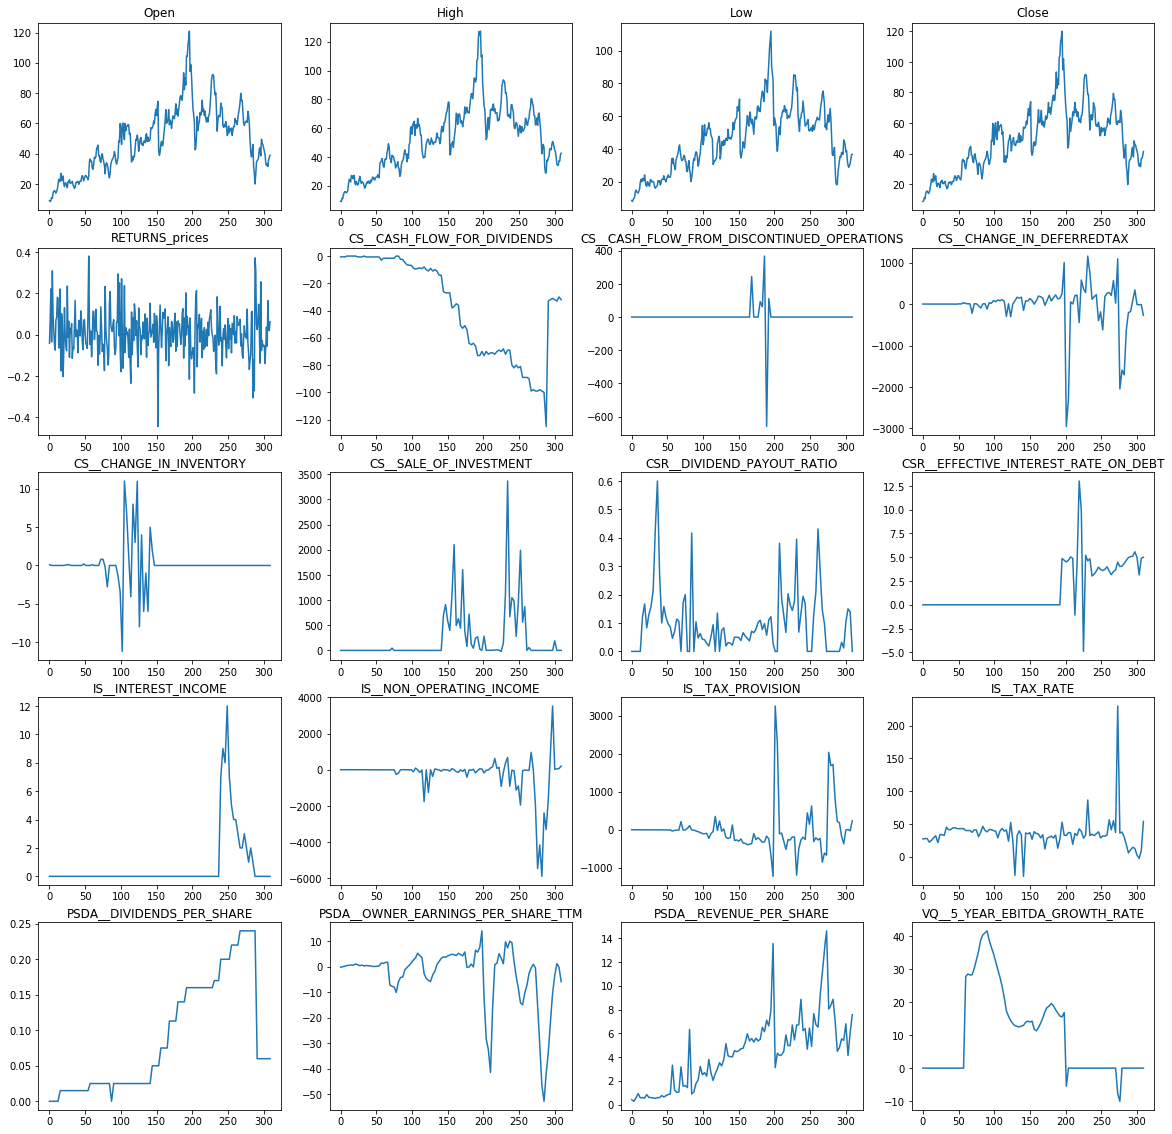

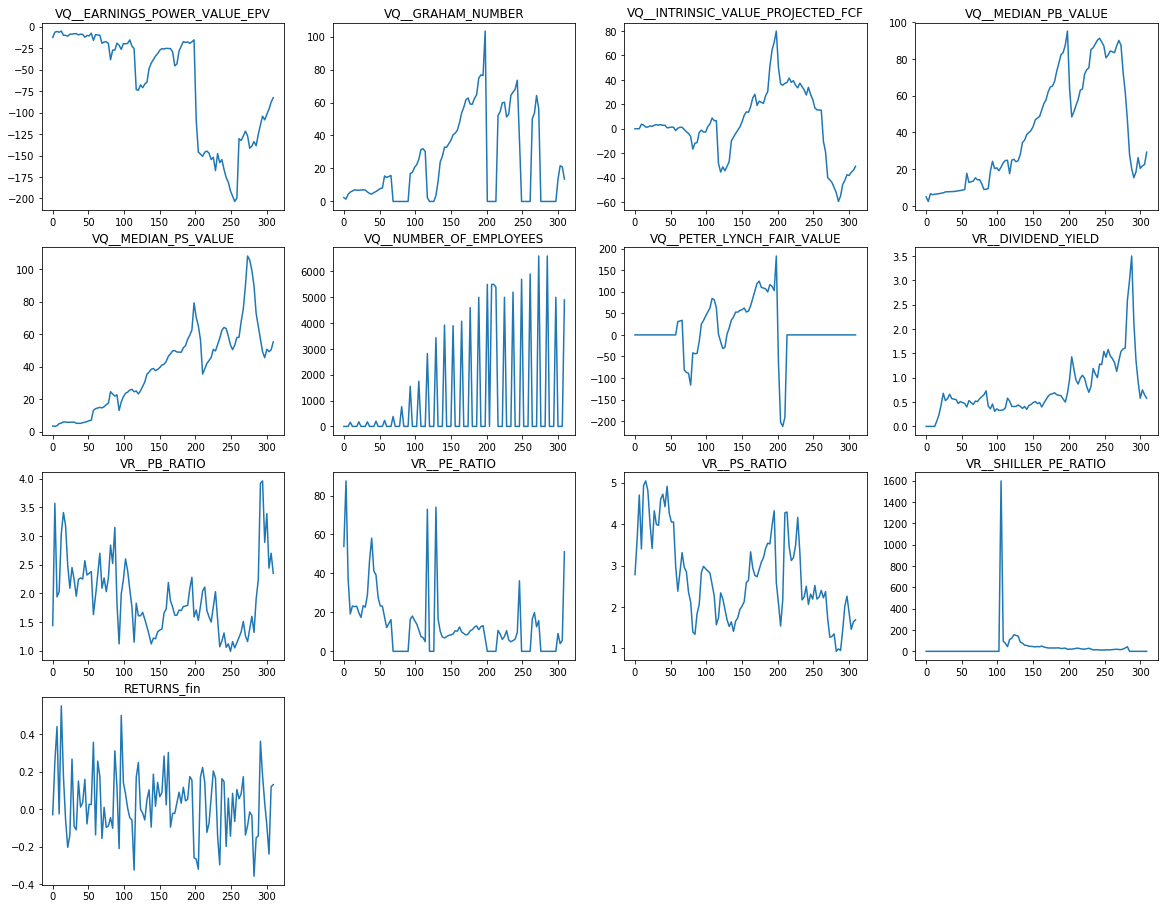

In [47]:
dfDvn.drop(['Year','Month'], axis=1, inplace=True)
plt.clf()
i = 1
plt.figure(figsize=(20,20))
cols = dfDvn.columns
for col in cols:    
    plt.subplot(5, 4, i)
    plt.plot(dfDvn[col].values)
    plt.title(col)    
    if i == 20:
        i=0
        plt.show()
        plt.figure(figsize=(20,20))
    i += 1

In [48]:
#Predigo solo el último valor, es decir, para el 2017 devuelvo lo mismo que obtuve en 2016
#El rmse será el error producido entre el valor real de 2017 y el que se devolvió (valor a 2016)
#Esto me va a servir para comparar este modelo con el resto
persistence_model = list()
group = dfDvn.loc[:,'RETURNS_prices']
test_y,predictions,rmse_dvn = create_model(group, 1)                                                     
#persistence_model.append({'code': code, 'prediction':predictions, 'rmse': rmse})

In [50]:
from statsmodels.tsa.vector_ar.var_model import VAR

#creating the train and validation set
train = dfDvn[:int(0.8*(len(dfDvn)))]
valid = dfDvn[int(0.8*(len(dfDvn))):]

#fit the model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation    
p = model_fit.forecast(model_fit.y, steps=len(valid))
#predictions.append({'codigo':c, 'prediction':p, 'valid': valid}) 


cols = dfDvn.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(p)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(p)):
        pred.iloc[i][j] = p[i][j]
    #check rmse
try:
    rmse_var = sqrt(mean_squared_error(pred['RETURNS_prices'], valid['RETURNS_prices']))
    print('rmse(VAR) value for RETURNS is:', rmse_var, 'vs rmse(base)',rmse_dvn)      
except:
    pass   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


rmse(VAR) value for RETURNS is: 0.9411949477807952 vs rmse(base) 0.04251186236594251
